# *PROJECT OVERVIEW*

The objective of this project is to simulate the active learning process with dynamic threshold, considering the same model structure applied on data from wearable devices of the same type, attached in differnt positions of the body.

From this, we can evaluate the evolution of the performances depending on the position of the sensor.

The dataset used is MHEALTHDATASET.

It is composed by body motion and vital signs recordings of 10 volunteers, while performing 12 physical activities. Each subject was wearing 3 wearable devices placed on its chest, right wrist and left ankle, acquiring a total of 23 features (acceleration, gyroscope, magnetometer and ECG). All sensing modalities are recorded at a sampling rate of 50 Hz.



The main expected results is the improvement of f1-score of the model for each label during active learning process.
Another possible expected result is the decrease of queries asked during active learning process. However, considering the dynamic threshold which follows the evolution of the knowledge of the model, this is not the case.

These results should be obtained considering the fine-tuned subject for sure, but they could also be obtained considering a general subject if the behavior of them is similar; however, this is not the case.

# **ENVIRONMENT**

In this section, we import necessary libraries, set the runtime on GPU if available and the seed for the random processes applied during the whole code.

This section must be run at the beginning of the work.

In [ ]:
# IMPORT LIBRARIES

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from math import sqrt, exp
import numpy as np
from scipy.stats import skew
from scipy.signal import correlate
from tqdm import tqdm
from scipy.stats import kurtosis
from scipy.stats import iqr
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import pickle
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from collections import Counter
import random
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score


In [ ]:
# USE GPU, IF AVAILABLE

# Check GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if tf.config.experimental.list_physical_devices('GPU'):
    print("GPU Device Found: ", tf.config.experimental.list_physical_devices('GPU'))
else:
    print("No GPU Device Found")

# Verify TensorFlow GPU usage
print("Is TensorFlow using GPU:", tf.test.is_built_with_cuda())
print("Is GPU available:", tf.test.is_gpu_available())

# Force TensorFlow to use GPU, if not already using it
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Num GPUs Available:  1
GPU Device Found:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Is TensorFlow using GPU: True
Is GPU available: True


In [ ]:
# SET SEED FOR ALL THE CODE

SEED = 2

np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


# **PRE-PROCESSING**

In this section, the goal is to perform the pre-process of the MHEALTHDATASET dataset to identify the data to be processed and to extract samples in a format suitable for the following model application. Here are the steps:

1. Cleaning
  - The chest sensor only acquired acceleration measurements about the physical dynamic of the subject, and not gyroscope and magnetometer. So, I decided to remove it. In this way, I will work only on the other two sensors, which acquired the same data
  - During the "not classified" activities the label assigned is 0. So, I decided to remove all the rows with this label
  - NA or NULL values were not present

2. Filtering
  - For a better understanding of the patterns in the features, I applied a filter. I decided to smooth the evolution of the signal, by applying a Gaussian-Weighted Moving Average
  - As consequence of the filter, at the beginning and at the end of each signal a constant value remained, due to the absence of padding. Because of this, I decided to remove these parts, which are inconsistent with respect to the whole signal

3. Normalizing
  - I normalized the signal considering each subject separately. In this way, no significant differences between subjects should arise and they will appear more "equal"
  - I decided not to standardize, because the distributions of the features are not suitable

4. Balancing
  - Label 12 had about 1/3 occurrencies with respect to the other labels. So, I decided to apply SMOTE augmentation on it, to reach a number of occurrencies equal to the average of the other labels

5. Segmenting
  - I used a window length of 2 seconds for each sample. This is an amount of time sufficient to identify all the activities performed and to extract a consistent number of samples
  - At each segment extracted, I set the label as the most frequently present, using mode
  - Once the bound of data is reached I stop segmenting. Due to this, a part of data will be lost, but also in this case it's a negligible part with respect to the whole dataset

At the end of the section, all the pre-processed data are saved in Drive. In this way, it is possible to run this section only once and not on following executions of the code.

## Importing

In [ ]:
# CONNECT DRIVE

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# IMPORT DATASET

n_sub = 10

input_data_dir = 'drive/MyDrive/ColabData Domotics/Project/MHEALTHDATASET'
filenames = [f'mHealth_subject{i+1}' for i in range(n_sub)]

df = []
for i in range(n_sub):
    df.append(pd.read_csv(f'{input_data_dir}/{filenames[i]}.log', sep='\t'))

# Look at head
df[4].head() # 24 columns

,-8.3532,2.5062,-2.406,-1.821,-1.1889,0.39931,-9.4774,-2.199,0.087199,-0.70544,...,-1.4596,-10.256,-2.5961,0.38431,-0.86653,-0.65517,0.58703,22.796,29.748,0
0,-7.0730,2.1373,-2.6182,-2.0345,-1.3689,1.08420,-8.8761,-1.4746,0.087199,-0.70544,...,-1.61570,-9.6925,-2.2450,0.38431,-0.86653,-0.65517,-2.5070,18.5990,24.3130,0
1,-7.6434,2.3723,-2.4497,-2.2773,-1.4443,2.24080,-9.8723,-1.0962,0.087199,-0.70544,...,-1.63350,-8.9590,-1.8959,0.38431,-0.86653,-0.65517,-6.9379,6.3932,15.3210,0
2,-8.0995,2.4517,-2.7688,-2.4155,-1.4903,1.80160,-9.8628,-1.1314,0.063080,-0.71482,...,0.29969,-7.7175,-2.7505,0.38431,-0.86653,-0.65517,-12.2450,-3.6440,4.4847,0
3,-8.3307,2.3913,-3.0164,-2.1852,-1.3940,0.44444,-9.9628,-1.2333,0.063080,-0.71482,...,0.68226,-8.1037,-3.3739,0.40784,-0.88501,-0.66164,-17.3770,3.7383,-6.5221,0
4,-8.7935,2.8082,-2.7473,-1.9383,-1.3229,1.04350,-9.7058,-1.2769,0.063080,-0.71482,...,-0.74657,-10.2440,-1.3663,0.40784,-0.88501,-0.66164,-13.5970,4.7540,-10.0670,0


In [ ]:
# Verify the shape of each subject's data
for i in range(n_sub):
    print(df[i].shape)

(161279, 24)
(130560, 24)
(122111, 24)
(116735, 24)
(119807, 24)
(98303, 24)
(104447, 24)
(129023, 24)
(135167, 24)
(98303, 24)


In [ ]:
# INSERT COLUMN TITLES (to concatenate in the correct way)

col_titles = [
    'accX_chest', 'accY_chest', 'accZ_chest',
    'EC1_chest', 'EC2_chest',

    'accX_lank', 'accY_lank', 'accZ_lank',
    'gyroX_lank', 'gyroY_lank', 'gyroZ_lank',
    'magX_lank', 'magY_lank', 'magZ_lank',

    'accX_rarm', 'accY_rarm', 'accZ_rarm',
    'gyroX_rarm', 'gyroY_rarm', 'gyroZ_rarm',
    'magX_rarm', 'magY_rarm', 'magZ_rarm',

    'label'
]

# Iterate through the list of DataFrames, set the column titles and identify the user
for i in range(n_sub):
    df[i].columns = col_titles
    df[i]['user'] = i # add 'user' column

# Verify final result
df[4].head()

,accX_chest,accY_chest,accZ_chest,EC1_chest,EC2_chest,accX_lank,accY_lank,accZ_lank,gyroX_lank,gyroY_lank,...,accY_rarm,accZ_rarm,gyroX_rarm,gyroY_rarm,gyroZ_rarm,magX_rarm,magY_rarm,magZ_rarm,label,user
0,-7.0730,2.1373,-2.6182,-2.0345,-1.3689,1.08420,-8.8761,-1.4746,0.087199,-0.70544,...,-9.6925,-2.2450,0.38431,-0.86653,-0.65517,-2.5070,18.5990,24.3130,0,4
1,-7.6434,2.3723,-2.4497,-2.2773,-1.4443,2.24080,-9.8723,-1.0962,0.087199,-0.70544,...,-8.9590,-1.8959,0.38431,-0.86653,-0.65517,-6.9379,6.3932,15.3210,0,4
2,-8.0995,2.4517,-2.7688,-2.4155,-1.4903,1.80160,-9.8628,-1.1314,0.063080,-0.71482,...,-7.7175,-2.7505,0.38431,-0.86653,-0.65517,-12.2450,-3.6440,4.4847,0,4
3,-8.3307,2.3913,-3.0164,-2.1852,-1.3940,0.44444,-9.9628,-1.2333,0.063080,-0.71482,...,-8.1037,-3.3739,0.40784,-0.88501,-0.66164,-17.3770,3.7383,-6.5221,0,4
4,-8.7935,2.8082,-2.7473,-1.9383,-1.3229,1.04350,-9.7058,-1.2769,0.063080,-0.71482,...,-10.2440,-1.3663,0.40784,-0.88501,-0.66164,-13.5970,4.7540,-10.0670,0,4


In [ ]:
# CONCATENATE DATASETS IN A SINGLE ONE

df = pd.concat(df, ignore_index=True)

# Verify shape
print(df.shape)
df.head()

(1215735, 25)


,accX_chest,accY_chest,accZ_chest,EC1_chest,EC2_chest,accX_lank,accY_lank,accZ_lank,gyroX_lank,gyroY_lank,...,accY_rarm,accZ_rarm,gyroX_rarm,gyroY_rarm,gyroZ_rarm,magX_rarm,magY_rarm,magZ_rarm,label,user
0,-9.8489,0.52404,0.37348,0.004186,0.016745,2.3876,-9.5080,0.68389,0.085343,-0.83865,...,-4.3198,0.023595,-0.44902,-1.0103,0.034483,-2.16320,-0.882540,0.326570,0,0
1,-9.6602,0.18185,0.43742,0.016745,0.037677,2.4086,-9.5674,0.68113,0.085343,-0.83865,...,-4.2772,0.275720,-0.44902,-1.0103,0.034483,-1.61750,-0.165620,-0.030693,0,0
2,-9.6507,0.21422,0.24033,0.079540,0.117220,2.1814,-9.4301,0.55031,0.085343,-0.83865,...,-4.3163,0.367520,-0.45686,-1.0082,0.025862,-1.07710,0.006945,-0.382620,0,0
3,-9.7030,0.30389,0.31156,0.221870,0.205130,2.4173,-9.3889,0.71098,0.085343,-0.83865,...,-4.1459,0.407290,-0.45686,-1.0082,0.025862,-0.53684,0.175900,-1.095500,0,0
4,-9.6511,0.23261,0.42094,0.154890,0.138150,2.2639,-9.4493,0.61267,0.098330,-0.84240,...,-4.0449,0.506090,-0.45686,-1.0082,0.025862,0.18674,0.720440,-0.364480,0,0


## Cleaning

In [ ]:
# REMOVE FIRST SENSOR DATA (it has different features)

df = df.drop(['accX_chest', 'accY_chest', 'accZ_chest', 'EC1_chest', 'EC2_chest'], axis=1)

# Verify final shape
print(df.shape)
df.head()

(1215735, 20)


,accX_lank,accY_lank,accZ_lank,gyroX_lank,gyroY_lank,gyroZ_lank,magX_lank,magY_lank,magZ_lank,accX_rarm,accY_rarm,accZ_rarm,gyroX_rarm,gyroY_rarm,gyroZ_rarm,magX_rarm,magY_rarm,magZ_rarm,label,user
0,2.3876,-9.5080,0.68389,0.085343,-0.83865,-0.68369,-0.197990,-0.18151,0.582980,-8.6275,-4.3198,0.023595,-0.44902,-1.0103,0.034483,-2.16320,-0.882540,0.326570,0,0
1,2.4086,-9.5674,0.68113,0.085343,-0.83865,-0.68369,-0.374170,0.18723,0.438510,-8.5055,-4.2772,0.275720,-0.44902,-1.0103,0.034483,-1.61750,-0.165620,-0.030693,0,0
2,2.1814,-9.4301,0.55031,0.085343,-0.83865,-0.68369,-0.017271,0.18366,0.575710,-8.6279,-4.3163,0.367520,-0.45686,-1.0082,0.025862,-1.07710,0.006945,-0.382620,0,0
3,2.4173,-9.3889,0.71098,0.085343,-0.83865,-0.68369,-0.374390,-0.54671,0.445860,-8.7008,-4.1459,0.407290,-0.45686,-1.0082,0.025862,-0.53684,0.175900,-1.095500,0,0
4,2.2639,-9.4493,0.61267,0.098330,-0.84240,-0.68959,-0.722340,0.37420,0.010705,-8.7247,-4.0449,0.506090,-0.45686,-1.0082,0.025862,0.18674,0.720440,-0.364480,0,0


In [ ]:
# REMOVE ALL ROWS WITH LABEL 0 (no activity was done)

df = df[(df['label'] != 0)].reset_index(drop=True)

# Verify shape
print(df.shape)
df.head()

(343195, 20)


,accX_lank,accY_lank,accZ_lank,gyroX_lank,gyroY_lank,gyroZ_lank,magX_lank,magY_lank,magZ_lank,accX_rarm,accY_rarm,accZ_rarm,gyroX_rarm,gyroY_rarm,gyroZ_rarm,magX_rarm,magY_rarm,magZ_rarm,label,user
0,2.6493,-9.4517,0.37683,-0.20965,-0.88931,-0.50884,0.56366,0.54482,-0.73822,-2.8439,-9.0618,1.8177,-0.058824,-0.93429,-0.34483,0.355370,-0.37003,-0.35020,1,0
1,2.4157,-9.5306,0.40179,-0.20965,-0.88931,-0.50884,0.56810,0.91175,-0.88628,-2.9935,-9.2048,1.5189,-0.058824,-0.93429,-0.34483,0.719910,0.17803,0.37363,1,0
2,2.3865,-9.5991,0.48141,-0.20037,-0.86867,-0.50688,0.21110,0.54835,-1.01980,-2.8846,-9.1945,1.5507,-0.058824,-0.93429,-0.34483,0.355370,-0.37003,-0.35020,1,0
3,2.3758,-9.5997,0.42919,-0.20037,-0.86867,-0.50688,0.21565,1.28220,-1.17150,-2.9245,-9.1746,1.5413,-0.078431,-0.93429,-0.34052,0.357180,-0.18858,-0.35198,1,0
4,2.3239,-9.5406,0.40038,-0.20037,-0.86867,-0.50688,0.56810,0.91175,-0.88628,-2.8963,-9.2039,1.6127,-0.078431,-0.93429,-0.34052,-0.001887,-0.18867,-0.72017,1,0


In [ ]:
# CONTROL PRESENCE OF NaN OR MISSING VALUES

print(df.isna().any().any())
print(df.isnull().any().any())

False
False


## Filtering

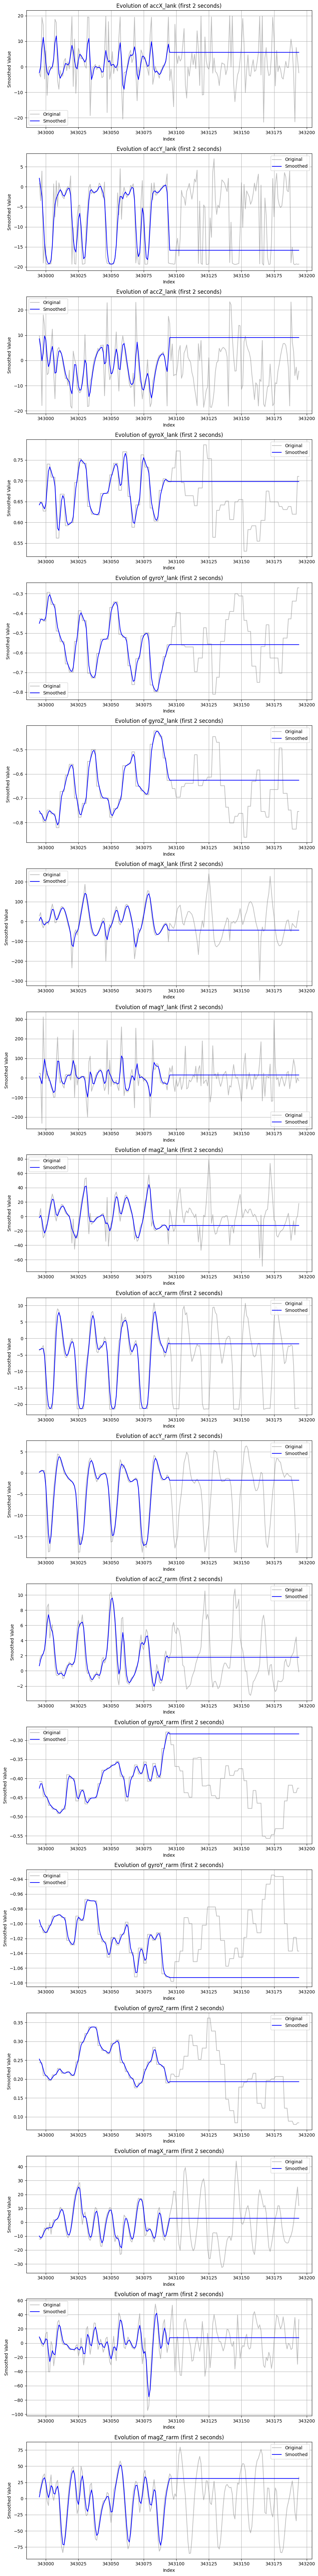

In [ ]:
# SMOOTH EACH FEATURE IN THE DATASET

window_comp = 200 # comparison size: 4 sec (50 Hz sample rate)
window_smooth = 200 # smooth size: 4 sec

df_small = df.iloc[-window_comp:] # small part of data for comparison with not smoothed signal

num_columns = len(df.columns)
fig, img = plt.subplots(num_columns - 2, 1, figsize=(10, 4 * num_columns))

for i, column in enumerate(df.columns[:-2]): # don't modify user and label
    df[column] = df[column].rolling(window=window_smooth, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")

    # Plot comparison
    img[i].plot(df_small.index, df_small[column], label='Original', alpha=0.5, color='gray')
    img[i].plot(df_small.index, df[column].iloc[-window_comp:], label='Smoothed', color='blue')
    img[i].set_xlabel('Index')
    img[i].set_ylabel('Smoothed Value')
    img[i].set_title(f'Evolution of {column} (first 2 seconds)')
    img[i].legend()
    img[i].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# DELETE BORDER PARTS, DUE TO SMOOTH FILTERING

df = df.iloc[int(window_smooth / 2) : -int(window_smooth / 2)].reset_index(drop=True)

# Verify shape
print(df.shape)
df.head()

(342995, 20)


,accX_lank,accY_lank,accZ_lank,gyroX_lank,gyroY_lank,gyroZ_lank,magX_lank,magY_lank,magZ_lank,accX_rarm,accY_rarm,accZ_rarm,gyroX_rarm,gyroY_rarm,gyroZ_rarm,magX_rarm,magY_rarm,magZ_rarm,label,user
0,2.319285,-9.534153,0.460484,-0.205974,-0.881385,-0.495416,0.465590,0.814116,-0.487992,-2.806078,-9.122057,1.762522,-0.073336,-0.942437,-0.340438,0.227011,0.800923,-0.647414,1,0
1,2.319454,-9.521526,0.480285,-0.206759,-0.879850,-0.496550,0.522618,0.722441,-0.460701,-2.786636,-9.111562,1.759251,-0.070585,-0.937383,-0.335145,0.327447,0.801619,-0.462131,1,0
2,2.379994,-9.574404,0.454444,-0.208715,-0.875253,-0.500016,0.512365,0.599192,-0.486905,-2.825696,-9.141583,1.769835,-0.067755,-0.932572,-0.330138,0.494855,0.937033,-0.266173,1,0
3,2.449435,-9.620218,0.434301,-0.210575,-0.870993,-0.503783,0.477407,0.487943,-0.551851,-2.893485,-9.180614,1.760691,-0.066231,-0.932572,-0.330418,0.581534,0.991056,-0.466104,1,0
4,2.424567,-9.589877,0.404073,-0.210575,-0.871965,-0.507345,0.555355,0.521146,-0.577359,-2.932474,-9.171627,1.765613,-0.064713,-0.937383,-0.336223,0.560411,0.879400,-0.826890,1,0


## Normalizing

In [ ]:
# Function to normalize each group
def normalize_group(group):
    scaler = MinMaxScaler()
    group[columns_to_normalize] = scaler.fit_transform(group[columns_to_normalize])
    return group

In [ ]:
# NORMALIZE

# List of columns to be normalized
columns_to_normalize = [
    'accX_lank', 'accY_lank', 'accZ_lank',
    'accX_rarm', 'accY_rarm', 'accZ_rarm',
    'gyroX_lank', 'gyroY_lank', 'gyroZ_lank',
    'gyroX_rarm', 'gyroY_rarm', 'gyroZ_rarm',
    'magX_lank', 'magY_lank', 'magZ_lank',
    'magX_rarm', 'magY_rarm', 'magZ_rarm'
]

# Apply normalization to each user's data
df = df.groupby('user').apply(normalize_group)

# Drop the 'user' index added by groupby
df.reset_index(drop=True, inplace=True)

# Verify shape
print(df.shape)
df.head()

(342995, 20)


,accX_lank,accY_lank,accZ_lank,gyroX_lank,gyroY_lank,gyroZ_lank,magX_lank,magY_lank,magZ_lank,accX_rarm,accY_rarm,accZ_rarm,gyroX_rarm,gyroY_rarm,gyroZ_rarm,magX_rarm,magY_rarm,magZ_rarm,label,user
0,0.609731,0.320898,0.586037,0.402797,0.456358,0.522405,0.531576,0.547211,0.551308,0.469972,0.240775,0.465970,0.518457,0.374978,0.192482,0.537083,0.525316,0.524349,1,0
1,0.609735,0.321314,0.586626,0.402535,0.456894,0.522090,0.531680,0.546985,0.551375,0.470451,0.241034,0.465892,0.519798,0.376532,0.195311,0.537320,0.525317,0.524517,1,0
2,0.611268,0.319574,0.585857,0.401882,0.458498,0.521128,0.531662,0.546681,0.551310,0.469488,0.240292,0.466144,0.521177,0.378012,0.197989,0.537716,0.525569,0.524695,1,0
3,0.613027,0.318067,0.585258,0.401261,0.459985,0.520082,0.531598,0.546407,0.551150,0.467816,0.239326,0.465927,0.521919,0.378012,0.197839,0.537921,0.525670,0.524513,1,0
4,0.612397,0.319065,0.584359,0.401261,0.459646,0.519093,0.531740,0.546489,0.551087,0.466855,0.239549,0.466044,0.522659,0.376532,0.194735,0.537871,0.525462,0.524187,1,0


## Balancing

In [ ]:
# LOOK AT OCCURRENCIES OF EACH LABEL

n_act = 12
label_counts = []

for i in range(1, n_act + 1):
    label_counts.append((df['label'] == i).sum())
    print(f'Label {i}: ', label_counts[-1], 'repetitions')

# 10 (subjects) * 50 (Hz) * 60 (secs in a min) = 30,000 (ideal repetitions for 1 min tasks => good for label 1 -> 11)
# labels 1 -> 11 have comparable dimensions
# label 12 has almost 1/3 observations

Label 1:  30620 repetitions
Label 2:  30720 repetitions
Label 3:  30720 repetitions
Label 4:  30720 repetitions
Label 5:  30720 repetitions
Label 6:  28315 repetitions
Label 7:  29441 repetitions
Label 8:  29337 repetitions
Label 9:  30720 repetitions
Label 10:  30720 repetitions
Label 11:  30720 repetitions
Label 12:  10242 repetitions


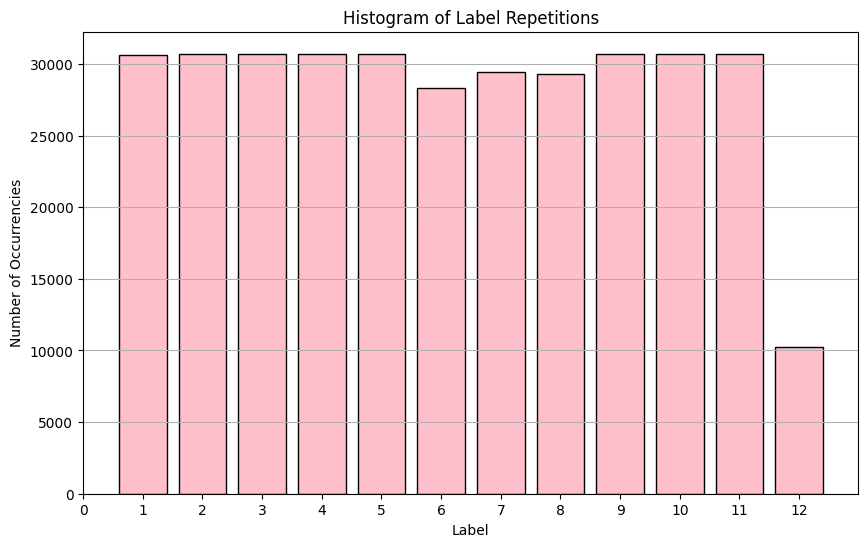

In [ ]:
# SHOW OCCURRENCIES

plt.figure(figsize=(10, 6))
plt.bar(range(1, n_act + 1), label_counts, color='pink', edgecolor='black')
plt.xlabel('Label')
plt.ylabel('Number of Occurrencies')
plt.title('Histogram of Label Repetitions')
plt.xticks(range(n_act + 1))
plt.grid(axis='y')
plt.show()

In [ ]:
# APPLY SMOTE ON LABEL 12

# Separate features, label and user variables
X = df.drop(['label', 'user'], axis=1)
y = df['label']
users = df['user']

resampled_data = []

# Iterate over each user to keep equality between them
for user in users.unique():
    user_indices = (users == user)

    X_user = X[user_indices]
    y_user = y[user_indices]

    # Find average of labels occurrences excluding label 12
    label_counts = y_user.value_counts()
    average_count = int(label_counts.loc[(label_counts.index != 12)].mean())

    # Apply SMOTE
    smote = SMOTE(sampling_strategy={12: average_count}, random_state=SEED)
    X_res, y_res = smote.fit_resample(X_user, y_user)

    # Combine the resampled data back into a DataFrame and add the user column
    df_resampled_user = pd.concat([X_res, y_res], axis=1)
    df_resampled_user['user'] = user

    resampled_data.append(df_resampled_user)

df = pd.concat(resampled_data, axis=0).reset_index(drop=True)

Label 1:  30620 repetitions
Label 2:  30720 repetitions
Label 3:  30720 repetitions
Label 4:  30720 repetitions
Label 5:  30720 repetitions
Label 6:  28315 repetitions
Label 7:  29441 repetitions
Label 8:  29337 repetitions
Label 9:  30720 repetitions
Label 10:  30720 repetitions
Label 11:  30720 repetitions
Label 12:  30246 repetitions


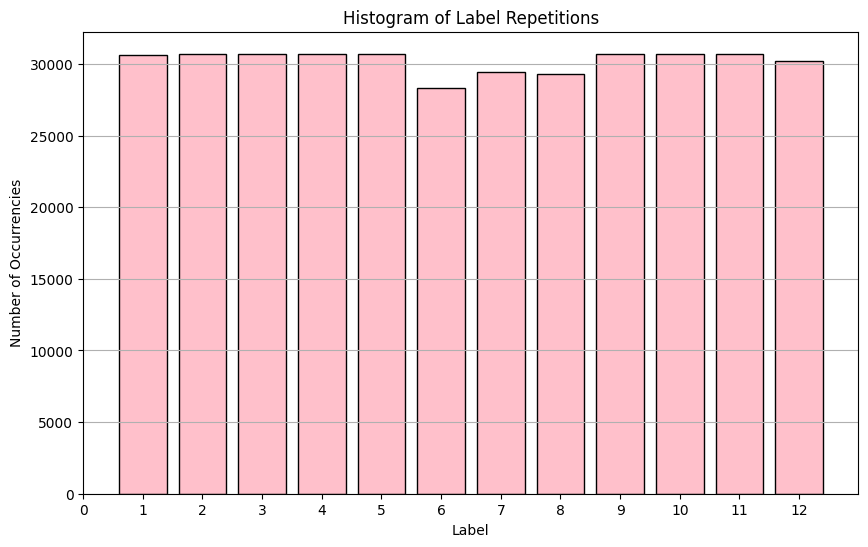

In [ ]:
# CONTROL FINAL RESULT

label_counts = []

for i in range(1, n_act + 1):
    label_counts.append((df['label'] == i).sum())
    print(f'Label {i}: ', label_counts[-1], 'repetitions')

plt.figure(figsize=(10, 6))
plt.bar(range(1, n_act + 1), label_counts, color='pink', edgecolor='black')
plt.xlabel('Label')
plt.ylabel('Number of Occurrencies')
plt.title('Histogram of Label Repetitions')
plt.xticks(range(n_act + 1))  # Ensure x-axis labels match the labels
plt.grid(axis='y')
plt.show()

## Segmenting

In [ ]:
# SPLIT DATA IN SEGMENTS

window_len = 2  # each segment is 2 sec long
sampling_rate = 50  # 50 Hz

acc_samples1, gyr_samples1, mag_samples1 = [], [], []
acc_samples2, gyr_samples2, mag_samples2 = [], [], []
labels, user_ids = [], []

start_idx = 0

while start_idx + window_len * sampling_rate <= len(df): # stop when bound is reached
    end_idx = start_idx + window_len * sampling_rate
    tmp_df = df.iloc[start_idx:end_idx]

    # Check if all data in tmp_df belongs to the same user
    user = tmp_df['user'].iloc[0]

    if (tmp_df['user'] == user).all():
        # Create samples
        acc_win1 = tmp_df[['accX_lank', 'accY_lank', 'accZ_lank']].to_numpy()
        gyr_win1 = tmp_df[['gyroX_lank', 'gyroY_lank', 'gyroZ_lank']].to_numpy()
        mag_win1 = tmp_df[['magX_lank', 'magY_lank', 'magZ_lank']].to_numpy()

        acc_win2 = tmp_df[['accX_rarm', 'accY_rarm', 'accZ_rarm']].to_numpy()
        gyr_win2 = tmp_df[['gyroX_rarm', 'gyroY_rarm', 'gyroZ_rarm']].to_numpy()
        mag_win2 = tmp_df[['magX_rarm', 'magY_rarm', 'magZ_rarm']].to_numpy()

        # Ensure the windows have right measurements
        if (len(acc_win1) == window_len * sampling_rate and
            len(gyr_win1) == window_len * sampling_rate and
            len(mag_win1) == window_len * sampling_rate and
            len(acc_win2) == window_len * sampling_rate and
            len(gyr_win2) == window_len * sampling_rate and
            len(mag_win2) == window_len * sampling_rate):

            # Get the most frequent label (mode) in tmp_df as label
            lab = tmp_df['label'].mode()[0]

            # Store data
            acc_samples1.append(acc_win1)
            gyr_samples1.append(gyr_win1)
            mag_samples1.append(mag_win1)

            acc_samples2.append(acc_win2)
            gyr_samples2.append(gyr_win2)
            mag_samples2.append(mag_win2)

            labels.append(lab)
            user_ids.append(user)

    start_idx += window_len * sampling_rate

# Convert lists to numpy arrays
acc_samples1 = np.asarray(acc_samples1)
gyr_samples1 = np.asarray(gyr_samples1)
mag_samples1 = np.asarray(mag_samples1)

acc_samples2 = np.asarray(acc_samples2)
gyr_samples2 = np.asarray(gyr_samples2)
mag_samples2 = np.asarray(mag_samples2)

labels = np.asarray(labels)
user_ids = np.asarray(user_ids)

# Verify final shapes
print(f"Accelerometer data 1:   {acc_samples1.shape}")
print(f"Gyroscope data 1:       {gyr_samples1.shape}")
print(f"Magnetometer data 1:    {mag_samples1.shape}")

print(f"Accelerometer data 2:   {acc_samples2.shape}")
print(f"Gyroscope data 2:       {gyr_samples2.shape}")
print(f"Magnetometer data 2:    {mag_samples2.shape}")

print(f"\nLabels data:          {labels.shape}")
print(f"User IDs data:          {user_ids.shape}")


Accelerometer data 1:   (3620, 100, 3)
Gyroscope data 1:       (3620, 100, 3)
Magnetometer data 1:    (3620, 100, 3)
Accelerometer data 2:   (3620, 100, 3)
Gyroscope data 2:       (3620, 100, 3)
Magnetometer data 2:    (3620, 100, 3)

Labels data:            (3620,)
User IDs data:          (3620,)


## Saving samples

In [ ]:
# SAVE SAMPLES

samples = {
    "acc_samples1": acc_samples1,
    "gyr_samples1": gyr_samples1,
    "mag_samples1": mag_samples1,

    "acc_samples2": acc_samples2,
    "gyr_samples2": gyr_samples2,
    "mag_samples2": mag_samples2,

    "user_ids": user_ids,
    "labels": labels
}

project_path = "/content/drive/MyDrive/ColabData Domotics/Project"
filename = f"{project_path}/samples.txt"

with open(filename, 'wb') as f:
    pickle.dump(samples, f)

print("Samples saved successfully!")

del samples

Samples saved successfully!


# **PRE-TRAINING**

In this section the goal is to make the pre-train of the models on the two sensors' data.

At first, taking the samples created before, we need to split them in active learning, pre-train, evaluation and test sets. I made this process many times in different ways, obtaining different results:

1. Random shuffle: the first approach I tried is to ignore the subjects' differences. This is not even a real simulation of active learning, because it does not fine-tune on a particular subject (it instead would generalize to all subjects), but I used it to build the whole code from scratch and adjust it later. In this case, I shuffled all the data and then I splitted the final dataset randomly, taking

  - 80% of it for active learning
  - 10% of it for test
  - 8% of it for pre-train
  - 2% of it for validation

  However, the results were not good. The main reason is that the subjects are very different in performing activities and the model was not able to acquire more knowledge during active learning, because the pre-training already reached the best on general data.
  
  Another problem here was due to the small validation set, which gave me very "quantized" results because of the few combinations of it.

2. Split by subjects: the first evolution I made is considering different subjects for each set:

  - 7 subjects for active learning, to have many data for the process
  - 1 subject for test
  - 2 subjects for pre-train and validation

  Here the results were better than before, because the active learning is applied on subjects that are not known by the model. So, we can see the accuracy increasing a bit during active learning, because the model has a baseline and then it learns new subjects' movements. However, a similar problems as before was present: many subjects together for active learning are not a real case of fine-tune, in fact the improvement never reached high performances (~50%).
  
  Also considering the high difference between subjects, there could be a huge gap between the 2 ones of pre-train and the 7 ones of active learning. So, the model could also have an almost useless pre-train here.

3. 1 subject for active learning: the code I am proposing here splits the data depending on the subject as the case before, but in a realistic and more appropriate way:

  - 1 subject for active learning, to have a real fine-tune
  - 1 subject for test
  - 8 subjects for pre-train and validation

  In this way, the model is pre-trained on a larger number of subjects and acquires a bigger general knowledge as starting point. Then, the active learning is applied on a single subject, simulating the real fine-tuning.
  
  To make this, a strong data augmentation on the single subject used for active learning was needed.

4. LOSO: another approach that I implemented is the classical leave-one-subject-out. I made the same split as the last method listed, but applying the LOSO technique during pre-train. This method gave very good results, similar or even better to the previous ones. However, it was too expensive to perform on Colab, because of GPU limitations. So, I couldn't work on it.

After the split of samples, the pre-train process is performed. I repeated it for many different models: CNN1D, CNN2D, LSTM-1layer, LSTM-2layers, CNN1D + LSTM, BiLSTM, GRU, LSTM-3layers. At the end, I decided to use the CNN2D, due to the performances reached. I tried different values for what concerns the batch_size, but no big differences were found.

At the end of the section, the pre-trained models are saved in Drive. In this way, it is possible to run this section only once and not on following executions of the code.

## Split samples

In [ ]:
# CONNECT DRIVE

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# TAKE SAMPLES FROM DRIVE

project_path = "/content/drive/MyDrive/ColabData Domotics/Project"
filename = f"{project_path}/samples.txt"

with open(filename, 'rb') as f:
    dataset = pickle.load(f)

acc_samples1 = dataset["acc_samples1"]
gyro_samples1 = dataset["gyr_samples1"]
mag_samples1 = dataset["mag_samples1"]

acc_samples2 = dataset["acc_samples2"]
gyro_samples2 = dataset["gyr_samples2"]
mag_samples2 = dataset["mag_samples2"]

users = dataset["user_ids"]
labels = dataset["labels"]

# Prepare samples

samples1 = np.concatenate((acc_samples1, gyro_samples1, mag_samples1), axis=2)
samples2 = np.concatenate((acc_samples2, gyro_samples2, mag_samples2), axis=2)

# Verify shapes
print("Variables measured have dimensions:")
print(acc_samples1.shape)
print(gyro_samples1.shape)
print(mag_samples1.shape)
print()
print(acc_samples2.shape)
print(gyro_samples2.shape)
print(mag_samples2.shape)
print()
print("Final samples have dimensions:")
print(samples1.shape)
print(samples2.shape) # axis 2 has dim = 9: 3 (x, y, z) * 3 (acc, gyro, mag)
print()
print("Users and labels have dimensions:")
print(users.shape)
print(labels.shape)

Variables measured have dimensions:
(3620, 100, 3)
(3620, 100, 3)
(3620, 100, 3)

(3620, 100, 3)
(3620, 100, 3)
(3620, 100, 3)

Final samples have dimensions:
(3620, 100, 9)
(3620, 100, 9)

Users and labels have dimensions:
(3620,)
(3620,)


In [ ]:
# ONE-HOT-ENCODING FOR LABELS

enc = OneHotEncoder()
labels = enc.fit_transform(labels.reshape(-1,1)).toarray()

# Verify shape
print(labels.shape)

(3620, 12)


In [ ]:
# CONSIDER SAMPLES OF A SINGLE USER FOR ACTIVE LEARNING

# Find indices
user_indices = np.where(users == 9)[0]

# Extract samples and labels for user
samples1_active = samples1[user_indices]
samples2_active = samples2[user_indices]
labels_active = labels[user_indices]

# Verify shapes
print(samples1_active.shape)
print(samples2_active.shape)
print(labels_active.shape)

(355, 100, 9)
(355, 100, 9)
(355, 12)


In [ ]:
# REMOVE THEM FROM DATASET

samples1 = np.delete(samples1, user_indices, axis=0)
samples2 = np.delete(samples2, user_indices, axis=0)

users = np.delete(users, user_indices, axis=0)
labels = np.delete(labels, user_indices, axis=0)

print(samples1.shape)
print(samples2.shape)
print()
print(users.shape)
print(labels.shape)

(3265, 100, 9)
(3265, 100, 9)

(3265,)
(3265, 12)


In [ ]:
# AUGMENT WITH SMOTE SAMPLES FOR ACTIVE LEARNING

# Calculate the desired number of samples for each label: 10x the original number
unique_labels, counts = np.unique(labels_active.argmax(axis=1), return_counts=True)
desired_counts = {label: count * 10 for label, count in zip(unique_labels, counts)}

# Preserve original shapes for reshaping later
n_samples1, n_timesteps1, n_features1 = samples1_active.shape
n_samples2, n_timesteps2, n_features2 = samples2_active.shape

# Reshape to 2D for SMOTE
samples1_active = samples1_active.reshape((n_samples1, -1))
samples2_active = samples2_active.reshape((n_samples2, -1))

# Apply SMOTE with the desired sampling strategy
smote = SMOTE(sampling_strategy=desired_counts)

# Apply SMOTE separately on samples1 and samples2, with the same labels
labels1_active, labels2_active = labels_active, labels_active

samples1_active, labels1_active = smote.fit_resample(samples1_active, labels1_active.argmax(axis=1))
samples2_active, labels2_active = smote.fit_resample(samples2_active, labels2_active.argmax(axis=1))

# Reshape back to 3D
samples1_active = samples1_active.reshape((-1, n_timesteps1, n_features1))
samples2_active = samples2_active.reshape((-1, n_timesteps2, n_features2))

# Convert augmented labels back to one-hot encoding
labels1_active = enc.fit_transform(labels1_active.reshape(-1, 1)).toarray()
labels2_active = enc.fit_transform(labels2_active.reshape(-1, 1)).toarray()

# Verify shapes
print(samples1_active.shape)
print(samples2_active.shape)
print(labels1_active.shape)
print(labels2_active.shape)

(3550, 100, 9)
(3550, 100, 9)
(3550, 12)
(3550, 12)


/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (310) in class 0 will be larger than the number of samples in the majority class (class #0 -> 31)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (310) in class 1 will be larger than the number of samples in the majority class (class #0 -> 31)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (310) in class 2 will be larger than the number of samples in the majority class (class #0 -> 31)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (300) in class 3 will be larger than the number of samples in the majority class (class #0 -> 31)
  warnings.warn(
/usr/local/lib/p

In [ ]:
# CONSIDER SAMPLES OF ANOTHER SINGLE USER AS TEST, BOTH FOR PRE-TRAIN AND ACTIVE LEARNING

# Find indices
user_indices = np.where((users == 0))[0]

# Extract samples and labels for users 0 and 1
samples1_test = samples1[user_indices]
samples2_test = samples2[user_indices]

labels_test = labels[user_indices]

# Verify shapes
print(samples1_test.shape)
print(samples2_test.shape)
print(labels_test.shape)

(370, 100, 9)
(370, 100, 9)
(370, 12)


In [ ]:
# ALL OTHER SAMPLES ARE FOR PRE-TRAIN AND ITS VALIDATION

samples1_train = np.delete(samples1, user_indices, axis=0)
samples2_train = np.delete(samples2, user_indices, axis=0)

users_train = np.delete(users, user_indices, axis=0)
labels_train = np.delete(labels, user_indices, axis=0)

# Verify shapes
print(samples1_train.shape)
print(samples2_train.shape)
print(users_train.shape)
print(labels_train.shape)

(2895, 100, 9)
(2895, 100, 9)
(2895,)
(2895, 12)


In [ ]:
# SPLIT IN PRE-TRAIN AND VALIDATION

samples1_train, samples1_val, samples2_train, samples2_val, labels_train, labels_val = train_test_split(samples1_train, samples2_train, labels_train, test_size=0.2, random_state=SEED, shuffle=True)

# Verify shapes
print(samples1_train.shape)
print(samples2_train.shape)
print(labels_train.shape)
print()
print(samples1_val.shape)
print(samples2_val.shape)
print(labels_val.shape)

(2316, 100, 9)
(2316, 100, 9)
(2316, 12)

(579, 100, 9)
(579, 100, 9)
(579, 12)


In [ ]:
# SAVE PREPARED SAMPLES

prepared_samples = {
    "samples1_train": samples1_train,
    "samples1_active": samples1_active,
    "samples2_train": samples2_train,
    "samples2_active": samples2_active,
    "labels_train": labels_train,
    "labels1_active": labels1_active,
    "labels2_active": labels2_active,
    "samples1_test": samples1_test,
    "samples1_val": samples1_val,
    "samples2_test": samples2_test,
    "samples2_val": samples2_val,
    "labels_test": labels_test,
    "labels_val": labels_val
}

filename = f"{project_path}/prepared_samples.pkl"

with open(filename, 'wb') as f:
    pickle.dump(prepared_samples, f)

print(f"Prepared samples saved to {filename}")


Prepared samples saved to /content/drive/MyDrive/ColabData Domotics/Project/prepared_samples.pkl


## Models

In [ ]:
# 1D CNN

def cnn_1D_acc_single_input(num_classes=12, print_summary=False):
  acc_input = tf.keras.layers.Input((100, 9), name="acc_input")
  x = tf.keras.layers.Conv1D(filters=32, kernel_size=32, strides=1, activation='relu', name="conv_1")(acc_input)
  x = tf.keras.layers.MaxPooling1D(pool_size=4, strides=1, name="max_pool_1")(x)
  x = tf.keras.layers.Conv1D(filters=64, kernel_size=32, strides=1, activation='relu', name="conv_2")(x)
  x = tf.keras.layers.MaxPooling1D(pool_size=4, strides=1, name="max_pool_2")(x)
  x = tf.keras.layers.Conv1D(filters=96, kernel_size=16, strides=1, activation='relu', name="conv_3")(x)
  x = tf.keras.layers.GlobalMaxPool1D(name='global_max_pooling')(x)
  x = tf.keras.layers.Dense(128, activation='relu', name="dense")(x)

  classification_out = tf.keras.layers.Dense(num_classes, activation='softmax', name="classification_out")(x)

  model = tf.keras.models.Model(inputs=acc_input, outputs=classification_out, name='cnn_1D_acc_single_input')

  if print_summary:
    print(model.summary())

  return model

model1 = cnn_1D_acc_single_input(print_summary=True)

Model: "cnn_1D_acc_single_input"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 acc_input (InputLayer)      [(None, 100, 9)]          0         
                                                                 
 conv_1 (Conv1D)             (None, 69, 32)            9248      
                                                                 
 max_pool_1 (MaxPooling1D)   (None, 66, 32)            0         
                                                                 
 conv_2 (Conv1D)             (None, 35, 64)            65600     
                                                                 
 max_pool_2 (MaxPooling1D)   (None, 32, 64)            0         
                                                                 
 conv_3 (Conv1D)             (None, 17, 96)            98400     
                                                                 
 global_max_pooling (Global  (None, 96)    

In [ ]:
# 2D CNN

def cnn_2D_acc_single_input(num_classes=12, print_summary=False):
  acc_input = tf.keras.layers.Input((100, 9, 1), name="acc_input") # 1 as channel of the "image"
  x = tf.keras.layers.Conv2D(filters=96, kernel_size=(16,9), strides=(1,1), activation='relu', name="conv_1")(acc_input)
  x = tf.keras.layers.GlobalMaxPool2D(name='global_max_pooling')(x)
  classification_out = tf.keras.layers.Dense(num_classes, activation='softmax', name="classification_out")(x)

  model = tf.keras.models.Model(inputs=acc_input, outputs=classification_out, name='cnn_2D_acc_single_input')

  if print_summary:
    print(model.summary())

  return model


In [ ]:
# 1 LSTM layer

def lstm_acc_single_input(num_classes=12, print_summary=False):
  acc_input = tf.keras.layers.Input((100, 9), name="acc_input")
  x = tf.keras.layers.LSTM(units=128, name="lstm")(acc_input)
  classification_out = tf.keras.layers.Dense(num_classes, activation='softmax', name="classification_out")(x)

  model = tf.keras.models.Model(inputs=acc_input, outputs=classification_out, name='lstm_acc_single_input')

  if print_summary:
    print(model.summary())

  return model

model3 = lstm_acc_single_input(print_summary=True)

Model: "lstm_acc_single_input"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 acc_input (InputLayer)      [(None, 100, 9)]          0         
                                                                 
 lstm (LSTM)                 (None, 128)               70656     
                                                                 
 classification_out (Dense)  (None, 12)                1548      
                                                                 
Total params: 72204 (282.05 KB)
Trainable params: 72204 (282.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# 2 LSTM layers

def multi_lstm(num_classes=12, print_summary=False):
  acc_input = tf.keras.layers.Input((100, 9), name="acc_input")
  x = tf.keras.layers.LSTM(units=128, return_sequences=True, name="lstm")(acc_input)
  x = tf.keras.layers.LSTM(units=128, name="lstm2")(x)
  classification_out = tf.keras.layers.Dense(num_classes, activation='softmax', name="classification_out")(x)

  model = tf.keras.models.Model(inputs=acc_input, outputs=classification_out, name='multi_lstm')

  if print_summary:
    print(model.summary())

  return model

model4 = multi_lstm(print_summary=True)

Model: "multi_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 acc_input (InputLayer)      [(None, 100, 9)]          0         
                                                                 
 lstm (LSTM)                 (None, 100, 128)          70656     
                                                                 
 lstm2 (LSTM)                (None, 128)               131584    
                                                                 
 classification_out (Dense)  (None, 12)                1548      
                                                                 
Total params: 203788 (796.05 KB)
Trainable params: 203788 (796.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# 1D CNN + LSTM

def cnn_1D_acc_single_input_with_lstm(num_classes=12, print_summary=False):
  acc_input = tf.keras.layers.Input((100, 9), name="acc_input")
  x = tf.keras.layers.Conv1D(filters=32, kernel_size=32, strides=1, activation='relu', name="conv_1")(acc_input)
  x = tf.keras.layers.MaxPooling1D(pool_size=4, strides=1, name="max_pool_1")(x)
  x = tf.keras.layers.Conv1D(filters=64, kernel_size=32, strides=1, activation='relu', name="conv_2")(x)
  x = tf.keras.layers.MaxPooling1D(pool_size=4, strides=1, name="max_pool_2")(x)
  x = tf.keras.layers.Conv1D(filters=96, kernel_size=16, strides=1, activation='relu', name="conv_3")(x)
  x = tf.keras.layers.LSTM(units=64, name="lstm")(x)
  classification_out = tf.keras.layers.Dense(num_classes, activation='softmax', name="classification_out")(x)

  model = tf.keras.models.Model(inputs=acc_input, outputs=classification_out, name='cnn_1D_acc_single_input_with_lstm')

  if print_summary:
    print(model.summary())

  return model

model5 = cnn_1D_acc_single_input_with_lstm(print_summary=True)

Model: "cnn_1D_acc_single_input_with_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 acc_input (InputLayer)      [(None, 100, 9)]          0         
                                                                 
 conv_1 (Conv1D)             (None, 69, 32)            9248      
                                                                 
 max_pool_1 (MaxPooling1D)   (None, 66, 32)            0         
                                                                 
 conv_2 (Conv1D)             (None, 35, 64)            65600     
                                                                 
 max_pool_2 (MaxPooling1D)   (None, 32, 64)            0         
                                                                 
 conv_3 (Conv1D)             (None, 17, 96)            98400     
                                                                 
 lstm (LSTM)                 (Non

In [ ]:
# BiLSTM

def bidirectional_lstm_acc_single_input(num_classes=12, print_summary=False):
  acc_input = tf.keras.layers.Input((100, 9), name="acc_input")
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, name="lstm"))(acc_input)
  classification_out = tf.keras.layers.Dense(num_classes, activation='softmax', name="classification_out")(x)

  model = tf.keras.models.Model(inputs=acc_input, outputs=classification_out, name='bidirectional_lstm_acc_single_input')

  if print_summary:
    print(model.summary())

  return model

model6 = bidirectional_lstm_acc_single_input(print_summary=True)

Model: "bidirectional_lstm_acc_single_input"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 acc_input (InputLayer)      [(None, 100, 9)]          0         
                                                                 
 bidirectional (Bidirection  (None, 256)               141312    
 al)                                                             
                                                                 
 classification_out (Dense)  (None, 12)                3084      
                                                                 
Total params: 144396 (564.05 KB)
Trainable params: 144396 (564.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# GRU

def gru_acc_single_input(num_classes=12, print_summary=False):
  acc_input = tf.keras.layers.Input((100, 9), name="acc_input")
  x = tf.keras.layers.GRU(units=64, name="gru")(acc_input)
  classification_out = tf.keras.layers.Dense(num_classes, activation='softmax', name="classification_out")(x)

  model = tf.keras.models.Model(inputs=acc_input, outputs=classification_out, name='gru_acc_single_input')

  if print_summary:
    print(model.summary())

  return model

model7 = gru_acc_single_input(print_summary=True)

Model: "gru_acc_single_input"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 acc_input (InputLayer)      [(None, 100, 9)]          0         
                                                                 
 gru (GRU)                   (None, 64)                14400     
                                                                 
 classification_out (Dense)  (None, 12)                780       
                                                                 
Total params: 15180 (59.30 KB)
Trainable params: 15180 (59.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# 3 LSTM layers + Fully Connected

def multi_lstm_fc(num_classes=12, print_summary=False):
    acc_input = tf.keras.layers.Input((100, 9), name="acc_input")

    x = tf.keras.layers.LSTM(units=128, return_sequences=True, name="lstm")(acc_input)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.LSTM(units=128, return_sequences=True, name="lstm2")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.LSTM(units=128, return_sequences=False, name="lstm3")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    classification_out = tf.keras.layers.Dense(num_classes, activation='softmax', name="fc")(x)

    model = tf.keras.models.Model(inputs=acc_input, outputs=classification_out, name='newModel')

    if print_summary:
        print(model.summary())

    return model

model8 = multi_lstm_fc(print_summary=True)

Model: "newModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 acc_input (InputLayer)      [(None, 100, 9)]          0         
                                                                 
 lstm (LSTM)                 (None, 100, 128)          70656     
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 lstm2 (LSTM)                (None, 100, 128)          131584    
                                                                 
 dropout_1 (Dropout)         (None, 100, 128)          0         
                                                                 
 lstm3 (LSTM)                (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0  

## Training baselines

In [ ]:
activities_mapper = {
    0: "Standing still",
    1: "Sitting and relaxing",
    2: "Lying down",
    3: "Walking",
    4: "Climbing stairs",
    5: "Waist bends forward",
    6: "Frontal elevation of arms",
    7: "Knees bending",
    8: "Cycling",
    9: "Jogging",
    10: "Running",
    11: "Jump"
}

In [ ]:
# SET PARAMETERS

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

n_epochs = 200
batch_size = 64


In [ ]:
# FIRST SENSOR PRE-TRAINING

model2_1 = cnn_2D_acc_single_input(print_summary=True)
model2_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

# Shuffling data
samples1_train, labels1_train = shuffle(samples1_train, labels_train, random_state=SEED)

print("\nTraining...")
history1 = model2_1.fit(x=samples1_train,
                  y=labels1_train,
                  batch_size = batch_size,
                  epochs = n_epochs,
                  validation_data = (samples1_val, labels_val),
                  callbacks=[early_stopping])

print("\nPredicting...")
y_preds = model2_1.predict(samples1_test)

y_preds = np.argmax(y_preds, axis=1)
y_targets = np.argmax(labels_test, axis=1)

classes = list(activities_mapper.values())
print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes, labels=np.array([i for i in range(len(classes))]), digits=4, zero_division=0))

Model: "cnn_2D_acc_single_input"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 acc_input (InputLayer)      [(None, 100, 9, 1)]       0         
                                                                 
 conv_1 (Conv2D)             (None, 85, 1, 96)         13920     
                                                                 
 global_max_pooling (Global  (None, 96)                0         
 MaxPooling2D)                                                   
                                                                 
 classification_out (Dense)  (None, 12)                1164      
                                                                 
Total params: 15084 (58.92 KB)
Trainable params: 15084 (58.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None

Training...
Epoch 1/200
37/37 [==============================] - 4s

In [ ]:
# SECOND SENSOR PRE-TRAINING

model2_2 = cnn_2D_acc_single_input(print_summary=True)
model2_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

# Shuffle data for train
samples2_train, labels2_train = shuffle(samples2_train, labels_train, random_state=SEED)

print("\nTraining...")
history2 = model2_2.fit(x=samples2_train,
                  y=labels2_train,
                  batch_size = batch_size,
                  epochs = n_epochs,
                  validation_data = (samples2_val, labels_val),
                  callbacks=[early_stopping])

print("\nPredicting...")
y_preds = model2_2.predict(samples2_test)

y_preds = np.argmax(y_preds, axis=1)
y_targets = np.argmax(labels_test, axis=1)

classes = list(activities_mapper.values())
print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes, labels=np.array([i for i in range(len(classes))]), digits=4, zero_division=0))

Model: "cnn_2D_acc_single_input"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 acc_input (InputLayer)      [(None, 100, 9, 1)]       0         
                                                                 
 conv_1 (Conv2D)             (None, 85, 1, 96)         13920     
                                                                 
 global_max_pooling (Global  (None, 96)                0         
 MaxPooling2D)                                                   
                                                                 
 classification_out (Dense)  (None, 12)                1164      
                                                                 
Total params: 15084 (58.92 KB)
Trainable params: 15084 (58.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None

Training...
Epoch 1/200
37/37 [==============================] - 1s

In [ ]:
# SAVE TRAINE MODELS

model2_1.save(f"{project_path}/model1")
model2_2.save(f"{project_path}/model2")

print(f"\nModel saved to {project_path}")


Model saved to /content/drive/MyDrive/ColabData Domotics/Project


# **ACTIVE LEARNING**

In this section the actual simulation of active learning process is performed.

I decided to wait for 32 queries before permorming each training, to increase the probability of having all labels at each step and consequently reduce the catastrophic forgetting. For the same reason, I also decided to add 16 random samples from pre-train set, to maintain the general knowledge acquired before.

I set the initial threshold as 1 following VAR-UNCERTAINTY algorithm and changing of 0.5% at each iteration. With the high starting point, at the beginning the model will ask many queries to adapt faster to the user; with the small variation, there will be more robust changes in time.

I decided to manually set the learning rate to 0.000001, because with the default value (0.001) there was a high bouncing during the evolution.

After the active learning processes, there are the most relevant plots of the results. First, a section regarding the evolution on the fine-tuned subject; then, a section regarding the evolution on the general knowledge.

## Import trained baselines

In [ ]:
# CONNECT DRIVE

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# IMPORT PRE-TRAINED MODELS FROM DRIVE

project_path = "/content/drive/MyDrive/ColabData Domotics/Project"

model1 = load_model(f"{project_path}/model1")
model2 = load_model(f"{project_path}/model2")

In [ ]:
# IMPORT SAMPLES FROM DRIVE

filename = f"{project_path}/prepared_samples.pkl"

# Load the prepared samples from the file
with open(filename, 'rb') as f:
    prepared_samples = pickle.load(f)

# Extract the data from the dictionary
samples1_train = prepared_samples["samples1_train"]
samples1_active = prepared_samples["samples1_active"]
samples2_train = prepared_samples["samples2_train"]
samples2_active = prepared_samples["samples2_active"]
labels_train = prepared_samples["labels_train"]
labels1_active = prepared_samples["labels1_active"]
labels2_active = prepared_samples["labels2_active"]
samples1_test = prepared_samples["samples1_test"]
samples1_val = prepared_samples["samples1_val"]
samples2_test = prepared_samples["samples2_test"]
samples2_val = prepared_samples["samples2_val"]
labels_test = prepared_samples["labels_test"]
labels_val = prepared_samples["labels_val"]

# Verify shapes
print(samples1_train.shape)
print(samples2_train.shape)
print(labels_train.shape)
print()
print(samples1_active.shape)
print(samples2_active.shape)
print(labels_active.shape)
print()
print(samples1_test.shape)
print(samples2_test.shape)
print(labels_test.shape)
print()
print(samples1_val.shape)
print(samples2_val.shape)
print(labels_val.shape)


(2316, 100, 9)
(2316, 100, 9)
(2316, 12)

(3550, 100, 9)
(3550, 100, 9)
(355, 12)

(370, 100, 9)
(370, 100, 9)
(370, 12)

(579, 100, 9)
(579, 100, 9)
(579, 12)


In [ ]:
activities_mapper = {
    0: "Standing still",
    1: "Sitting and relaxing",
    2: "Lying down",
    3: "Walking",
    4: "Climbing stairs",
    5: "Waist bends forward",
    6: "Frontal elevation of arms",
    7: "Knees bending",
    8: "Cycling",
    9: "Jogging",
    10: "Running",
    11: "Jump"
}

In [ ]:
# LOOK AT THE PRE-TRAINED SITUATION OF MODEL1

print("\nPredicting...")
y_preds = model1.predict(samples1_test)

y_preds = np.argmax(y_preds, axis=1)
y_targets = np.argmax(labels_test, axis=1)

classes = list(activities_mapper.values())
print("\nClassification Report:")

report = classification_report(y_targets, y_preds, target_names=classes, labels=np.array([i for i in range(len(classes))]), digits=4, zero_division=0)
print(report)

report = classification_report(y_targets, y_preds, target_names=classes, labels=np.array([i for i in range(len(classes))]), digits=4, zero_division=0, output_dict=True)
pre_f1_1 = report["weighted avg"]["f1-score"]




Predicting...
12/12 [==============================] - 0s 2ms/step

Classification Report:
                           precision    recall  f1-score   support

           Standing still     0.0000    0.0000    0.0000        30
     Sitting and relaxing     0.0000    0.0000    0.0000        30
               Lying down     1.0000    1.0000    1.0000        31
                  Walking     1.0000    0.9677    0.9836        31
          Climbing stairs     0.5918    0.9355    0.7250        31
      Waist bends forward     0.0000    0.0000    0.0000        31
Frontal elevation of arms     0.0000    0.0000    0.0000        30
            Knees bending     1.0000    0.7059    0.8276        34
                  Cycling     0.8824    0.9677    0.9231        31
                  Jogging     0.6078    1.0000    0.7561        31
                  Running     0.0000    0.0000    0.0000        30
                     Jump     0.9500    0.6333    0.7600        30

                 accuracy          

In [ ]:
# LOOK AT THE PRE-TRAINED SITUATION OF MODEL2

print("\nPredicting...")
y_preds = model2.predict(samples2_test)

y_preds = np.argmax(y_preds, axis=1)
y_targets = np.argmax(labels_test, axis=1)

classes = list(activities_mapper.values())
print("\nClassification Report:")

report = classification_report(y_targets, y_preds, target_names=classes, labels=np.array([i for i in range(len(classes))]), digits=4, zero_division=0)
print(report)

report = classification_report(y_targets, y_preds, target_names=classes, labels=np.array([i for i in range(len(classes))]), digits=4, zero_division=0, output_dict=True)
pre_f1_2 = report["weighted avg"]["f1-score"]



Predicting...
12/12 [==============================] - 0s 2ms/step

Classification Report:
                           precision    recall  f1-score   support

           Standing still     0.0000    0.0000    0.0000        30
     Sitting and relaxing     0.8571    1.0000    0.9231        30
               Lying down     0.9118    1.0000    0.9538        31
                  Walking     0.9655    0.9032    0.9333        31
          Climbing stairs     0.4681    0.7097    0.5641        31
      Waist bends forward     0.2364    0.4194    0.3023        31
Frontal elevation of arms     0.9375    1.0000    0.9677        30
            Knees bending     0.0000    0.0000    0.0000        34
                  Cycling     1.0000    0.9677    0.9836        31
                  Jogging     1.0000    0.3226    0.4878        31
                  Running     0.7692    1.0000    0.8696        30
                     Jump     0.7368    0.9333    0.8235        30

                 accuracy          

## Prepare parameters and data

In [ ]:
# SHUFFLE DATA

samples1_active, labels1_active = shuffle(samples1_active, labels1_active, random_state=SEED)
samples2_active, labels2_active = shuffle(samples2_active, labels2_active, random_state=SEED)

samples1_train, labels1_train = shuffle(samples1_train, labels_train, random_state=SEED)
samples2_train, labels2_train = shuffle(samples2_train, labels_train, random_state=SEED)

In [ ]:
# PARAMTERS FOR TRAINING DURING ACTIVE LEARNING

batch_size_active = 32
batch_size = 16
num_training_samples_per_batch = 16

num_epochs = 50

evaluation_frequency = 200

## Model 1

In [ ]:
# ACTIVE LEARNING SIMULATION OF MODEL1

# Initialize dynamic thresholding
threshold = 1
threshold_var = 0.005

# Initialize data to be saved during simulation
number_of_queries = 0
number_of_queries_per_evaluation = 0
current_iteration = 0

batch_x, batch_y = [], []

queries_evolution_per_evaluation = []

scores_evolution = []
fixed_test_scores = []
list_queries = []
thresholds_list = []
y_pred = []
y_pred_true = []

learning_rate = 0.000001
optimizer = Adam(learning_rate=learning_rate)

model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

for i in tqdm(range(len(samples1_active))):
    current_iteration += 1

    # Making predictions on real-time samples
    y_preds = model1.predict(samples1_active[i].reshape(1, 100, 9), verbose=0)
    prediction_certainty = np.max(y_preds[0])

    y_pred.append(np.argmax(y_preds))
    y_pred_true.append(np.argmax(labels1_active[i]))

    # Evaluate on the fixed test set at specified intervals
    if current_iteration % evaluation_frequency == 0:
        queries_evolution_per_evaluation.append(number_of_queries_per_evaluation)
        number_of_queries_per_evaluation = 0

        y_preds_on_test = model1.predict(samples1_test, verbose=0)
        y_preds_on_test = np.argmax(y_preds_on_test, axis=1)
        y_targets_on_test = np.argmax(labels_test, axis=1)

        report = classification_report(y_targets_on_test, y_preds_on_test, target_names=classes, digits=4, zero_division=0, output_dict=True)
        f1 = report["weighted avg"]["f1-score"]
        print(f" - f1-score accurcy: {f1}\n")
        fixed_test_scores.append(f1)
        scores_evolution.append((current_iteration, f1))

    # Active learning: update model if prediction certainty is below threshold
    if prediction_certainty < threshold:
        number_of_queries_per_evaluation += 1

        number_of_queries += 1
        batch_x.append(samples1_active[i])
        batch_y.append(labels1_active[i])

        # y_pred.append(np.argmax(y_preds))
        # y_pred_true.append(np.argmax(labels1_active[i]))

        list_queries.append(np.argmax(labels1_active[i]))

        threshold -= threshold * threshold_var

        assert len(batch_x) == len(batch_y)
        if len(batch_x) >= batch_size_active:
            # Add samples from the training set to prevent catastrophic forgetting
            training_indices = np.random.choice(len(samples1_train), num_training_samples_per_batch, replace=False)
            training_samples = samples1_train[training_indices]
            training_labels = labels1_train[training_indices]

            batch_x.extend(training_samples)
            batch_y.extend(training_labels)

            # Shuffle the batch data before fitting the model
            batch_x, batch_y = shuffle(batch_x, batch_y, random_state=SEED)

            # Update model
            model1.fit(x=np.array(batch_x), y=np.array(batch_y), epochs=num_epochs, batch_size=batch_size, verbose=0)

            batch_x, batch_y = [], []

    else:
        threshold += threshold * threshold_var

    thresholds_list.append(threshold)

  6%|▌         | 203/3550 [00:16<03:40, 15.21it/s]

 - f1-score accurcy: 0.5037745143641195



 11%|█▏        | 401/3550 [00:31<05:01, 10.43it/s]

 - f1-score accurcy: 0.48742230889062976



 17%|█▋        | 602/3550 [00:46<05:23,  9.12it/s]

 - f1-score accurcy: 0.4839834903931578



 23%|██▎       | 803/3550 [01:01<03:18, 13.82it/s]

 - f1-score accurcy: 0.485240865695938



 28%|██▊       | 1003/3550 [01:15<02:44, 15.52it/s]

 - f1-score accurcy: 0.485240865695938



 34%|███▍      | 1203/3550 [01:31<03:16, 11.97it/s]

 - f1-score accurcy: 0.4901937327506156



 39%|███▉      | 1402/3550 [01:47<03:54,  9.17it/s]

 - f1-score accurcy: 0.4877338096272381



 45%|████▌     | 1602/3550 [02:02<02:17, 14.16it/s]

 - f1-score accurcy: 0.47126109350344914



 51%|█████     | 1802/3550 [02:17<02:01, 14.41it/s]

 - f1-score accurcy: 0.4767209442441425



 56%|█████▋    | 2003/3550 [02:31<01:39, 15.62it/s]

 - f1-score accurcy: 0.48704653399129416



 62%|██████▏   | 2202/3550 [02:46<02:07, 10.58it/s]

 - f1-score accurcy: 0.48683735513761406



 68%|██████▊   | 2403/3550 [03:06<01:14, 15.48it/s]

 - f1-score accurcy: 0.49414105205639336



 73%|███████▎  | 2603/3550 [03:22<01:00, 15.66it/s]

 - f1-score accurcy: 0.4944366576285574



 79%|███████▉  | 2803/3550 [03:37<00:47, 15.68it/s]

 - f1-score accurcy: 0.4923067546323361



 85%|████████▍ | 3003/3550 [03:51<00:35, 15.53it/s]

 - f1-score accurcy: 0.4944366576285574



 90%|█████████ | 3202/3550 [04:06<00:25, 13.52it/s]

 - f1-score accurcy: 0.4923067546323361



 96%|█████████▌| 3402/3550 [04:20<00:09, 14.97it/s]

 - f1-score accurcy: 0.4923067546323361



100%|██████████| 3550/3550 [04:31<00:00, 13.09it/s]


### Results on fine-tuned subject

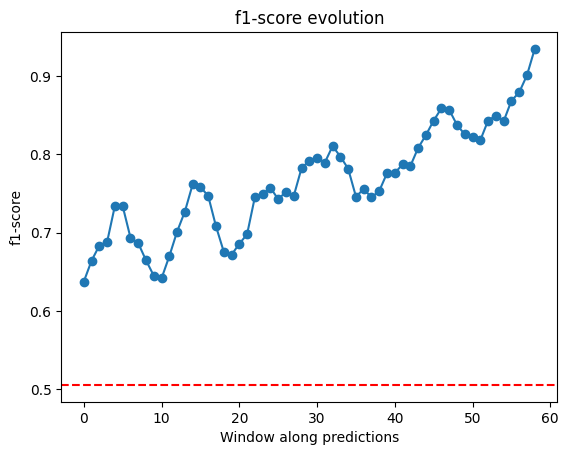

In [ ]:
# EVOLUTION OF F1-SCORE

window_size = 256
overlap = 200

step = window_size - overlap

y_win = [y_pred[i:i+window_size] for i in range(0, len(y_pred) - window_size + 1, step)]
y_win_true = [y_pred_true[i:i+window_size] for i in range(0, len(y_pred_true) - window_size + 1, step)]

assert(len(y_win) == len(y_win_true))
f1_scores = [f1_score(y_win_true[i], y_win[i], average='weighted') for i in range(len(y_win_true))]

plt.plot(range(len(f1_scores)), f1_scores, marker='o', linestyle='-')
plt.axhline(y=pre_f1_1, color='r', linestyle='--')
plt.title('f1-score evolution')
plt.xlabel('Window along predictions')
plt.ylabel('f1-score')
plt.show()


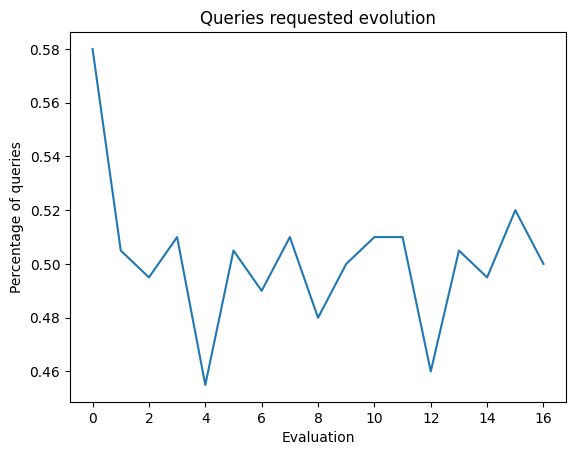

In [ ]:
# EVOLUTION OF QUERIES ASKED

plt.plot(range(len(queries_evolution_per_evaluation)), [x/200 for x in queries_evolution_per_evaluation])
plt.title('Queries requested evolution')
plt.xlabel('Evaluation')
plt.ylabel('Percentage of queries')
plt.show()

In [ ]:
print(f"Percentage of queries asked: {len(list_queries)/len(samples1_active) * 100:.2f}%")

Percentage of queries asked: 50.00%


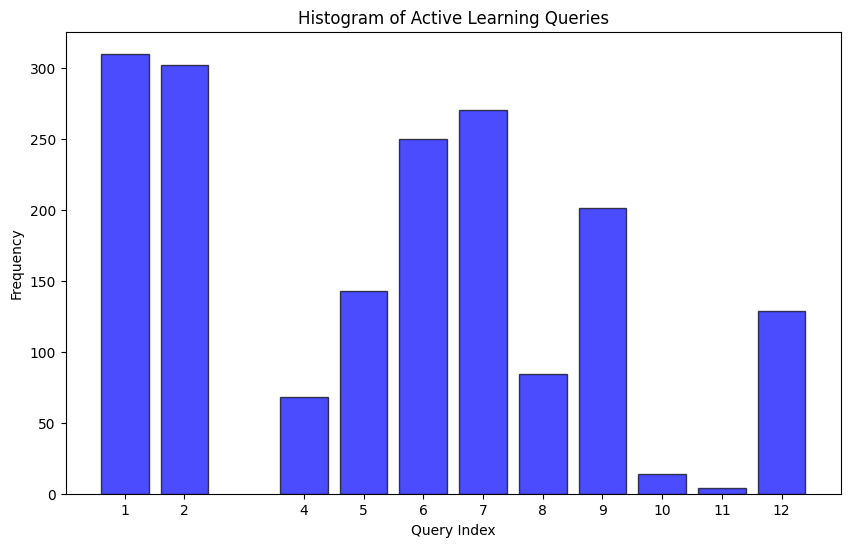

In [ ]:
# HISTOGRAM OF QUERIES PER LABEL

query_counts = Counter(list_queries)
indices = list(query_counts.keys())
frequencies = list(query_counts.values())

indices = [index + 1 for index in indices]

plt.figure(figsize=(10, 6))
plt.bar(indices, frequencies, color='blue', edgecolor='black', alpha=0.7)

plt.xlabel('Query Index')
plt.ylabel('Frequency')
plt.title('Histogram of Active Learning Queries')

plt.xticks(indices)
plt.show()


(0.0, 1.0)

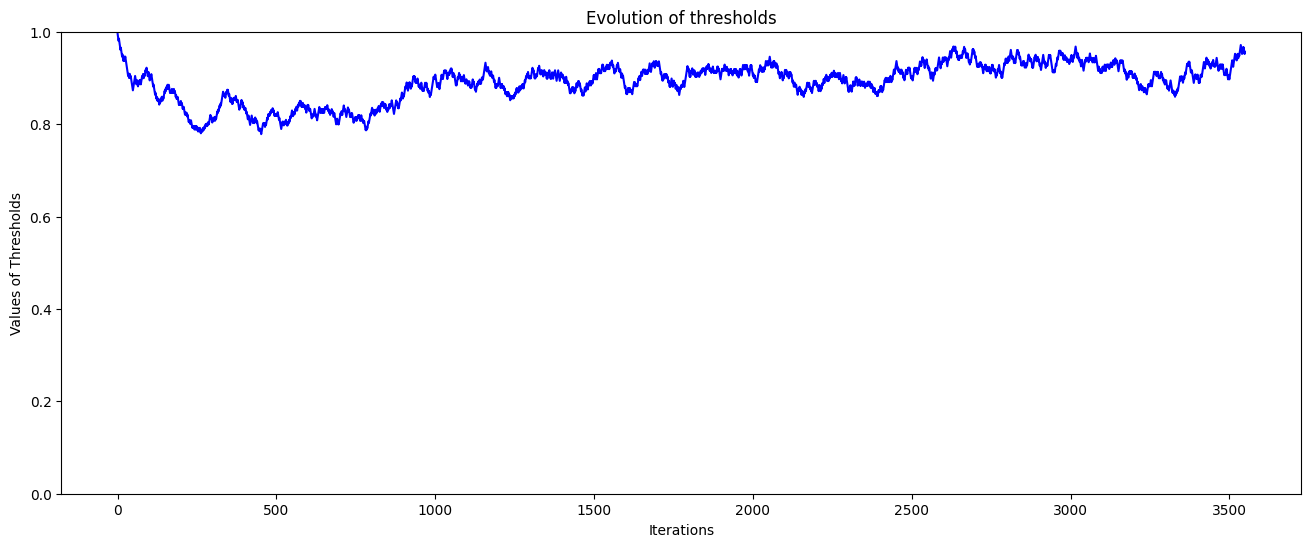

In [ ]:
# EVOLUTION OF THRESHOLD

plt.figure(figsize=(16, 6))

plt.plot(thresholds_list, color='blue')
plt.title('Evolution of thresholds')
plt.xlabel('Iterations')
plt.ylabel('Values of Thresholds')
plt.ylim([0,1])

### Results on fixed test subject

In [ ]:
print("\nPredicting...")
y_preds = model1.predict(samples1_test)

y_preds = np.argmax(y_preds, axis=1)
y_targets = np.argmax(labels_test, axis=1)

classes = list(activities_mapper.values())
print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes, labels=np.array([i for i in range(len(classes))]), digits=4, zero_division=0))


Predicting...
12/12 [==============================] - 0s 2ms/step

Classification Report:
                           precision    recall  f1-score   support

           Standing still     0.0000    0.0000    0.0000        30
     Sitting and relaxing     0.0000    0.0000    0.0000        30
               Lying down     1.0000    1.0000    1.0000        31
                  Walking     1.0000    0.9355    0.9667        31
          Climbing stairs     0.7714    0.8710    0.8182        31
      Waist bends forward     0.0000    0.0000    0.0000        31
Frontal elevation of arms     0.0000    0.0000    0.0000        30
            Knees bending     1.0000    0.2353    0.3810        34
                  Cycling     0.5849    1.0000    0.7381        31
                  Jogging     0.5636    1.0000    0.7209        31
                  Running     0.0000    0.0000    0.0000        30
                     Jump     0.9667    0.9667    0.9667        30

                 accuracy          

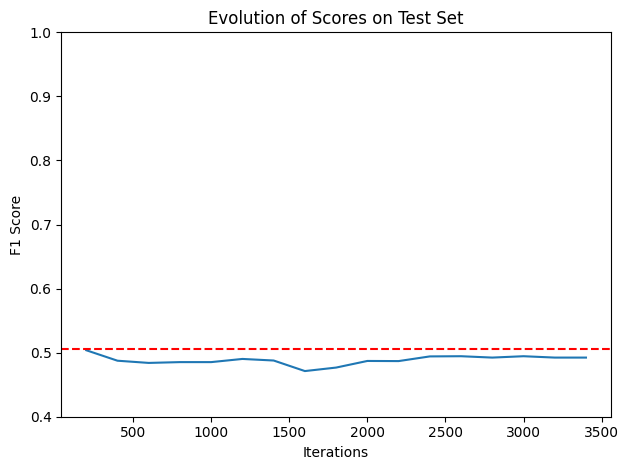

In [ ]:
# EVOLUTION OF F1-SCORE

scores_x, scores_y = zip(*scores_evolution)
plt.plot(scores_x, scores_y)
plt.axhline(y=pre_f1_1, color='r', linestyle='--')
plt.title('Evolution of Scores on Test Set')
plt.xlabel('Iterations')
plt.ylabel('F1 Score')
plt.ylim([0.4,1])

plt.tight_layout()
plt.show()


## Model 2

In [ ]:
# ACTIVE LEARNING SIMULATION OF MODEL2

# Initialize dynamic thresholding
threshold = 1
threshold_var = 0.005

# Initialize data to be saved during simulation
number_of_queries = 0
number_of_queries_per_evaluation = 0
current_iteration = 0

batch_x, batch_y = [], []

queries_evolution_per_evaluation = []

scores_evolution = []
fixed_test_scores = []
list_queries = []
thresholds_list = []
y_pred = []
y_pred_true = []

learning_rate = 0.000001
optimizer = Adam(learning_rate=learning_rate)

model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

for i in tqdm(range(len(samples2_active))):
    current_iteration += 1

    # Making predictions on real-time samples
    y_preds = model2.predict(samples2_active[i].reshape(1, 100, 9), verbose=0)
    prediction_certainty = np.max(y_preds[0])

    # Evaluate on the fixed test set at specified intervals
    if current_iteration % evaluation_frequency == 0:
        queries_evolution_per_evaluation.append(number_of_queries_per_evaluation)
        number_of_queries_per_evaluation = 0

        y_preds_on_test = model2.predict(samples2_test, verbose=0)
        y_preds_on_test = np.argmax(y_preds_on_test, axis=1)
        y_targets_on_test = np.argmax(labels_test, axis=1)

        report = classification_report(y_targets_on_test, y_preds_on_test, target_names=classes, digits=4, zero_division=0, output_dict=True)
        f1 = report["weighted avg"]["f1-score"]
        print(f" - f1-score accurcy: {f1}\n")
        fixed_test_scores.append(f1)
        scores_evolution.append((current_iteration, f1))

    # Active learning: update model if prediction certainty is below threshold
    if prediction_certainty < threshold:
        number_of_queries_per_evaluation += 1

        number_of_queries += 1
        batch_x.append(samples2_active[i])
        batch_y.append(labels2_active[i])

        y_pred.append(np.argmax(y_preds))
        y_pred_true.append(np.argmax(labels2_active[i]))

        list_queries.append(np.argmax(labels2_active[i]))

        threshold -= threshold * threshold_var

        assert len(batch_x) == len(batch_y)
        if len(batch_x) >= batch_size_active:
            # Add samples from the training set to prevent catastrophic forgetting
            training_indices = np.random.choice(len(samples1_train), num_training_samples_per_batch, replace=False)
            training_samples = samples1_train[training_indices]
            training_labels = labels2_train[training_indices]

            batch_x.extend(training_samples)
            batch_y.extend(training_labels)

            # Shuffle the batch data before fitting the model
            batch_x, batch_y = shuffle(batch_x, batch_y, random_state=SEED)

            # Update model
            model2.fit(x=np.array(batch_x), y=np.array(batch_y), epochs=num_epochs, batch_size=batch_size, verbose=0)

            batch_x, batch_y = [], []

    else:
        threshold += threshold * threshold_var

    thresholds_list.append(threshold)

  6%|▌         | 203/3550 [00:19<04:01, 13.84it/s]

 - f1-score accurcy: 0.6218784454235969



 11%|█▏        | 403/3550 [00:35<03:14, 16.22it/s]

 - f1-score accurcy: 0.6339711512751737



 17%|█▋        | 603/3550 [00:49<03:13, 15.20it/s]

 - f1-score accurcy: 0.6419344336240299



 23%|██▎       | 803/3550 [01:03<04:28, 10.25it/s]

 - f1-score accurcy: 0.6490181210528486



 28%|██▊       | 1002/3550 [01:17<04:14, 10.00it/s]

 - f1-score accurcy: 0.6424254619359622



 34%|███▍      | 1203/3550 [01:31<02:51, 13.70it/s]

 - f1-score accurcy: 0.6464290966740932



 40%|███▉      | 1403/3550 [01:45<02:17, 15.66it/s]

 - f1-score accurcy: 0.6495071231295908



 45%|████▌     | 1603/3550 [02:00<02:01, 15.99it/s]

 - f1-score accurcy: 0.6485246089420873



 51%|█████     | 1803/3550 [02:14<01:47, 16.23it/s]

 - f1-score accurcy: 0.6546204182788886



 56%|█████▋    | 2002/3550 [02:36<01:47, 14.35it/s]

 - f1-score accurcy: 0.6454215352076406



 62%|██████▏   | 2203/3550 [02:52<01:33, 14.47it/s]

 - f1-score accurcy: 0.6557811791763071



 68%|██████▊   | 2401/3550 [03:12<02:14,  8.54it/s]

 - f1-score accurcy: 0.6458858777377792



 73%|███████▎  | 2601/3550 [03:27<01:20, 11.86it/s]

 - f1-score accurcy: 0.6376008629716006



 79%|███████▉  | 2803/3550 [03:48<01:08, 10.86it/s]

 - f1-score accurcy: 0.6366906969966571



 85%|████████▍ | 3003/3550 [04:02<00:36, 14.86it/s]

 - f1-score accurcy: 0.6360370563987097



 90%|█████████ | 3203/3550 [04:17<00:21, 15.88it/s]

 - f1-score accurcy: 0.6300144166110028



 96%|█████████▌| 3401/3550 [04:37<00:11, 12.80it/s]

 - f1-score accurcy: 0.5644664877810385



100%|██████████| 3550/3550 [04:48<00:00, 12.30it/s]


### Results on fine-tuned subject

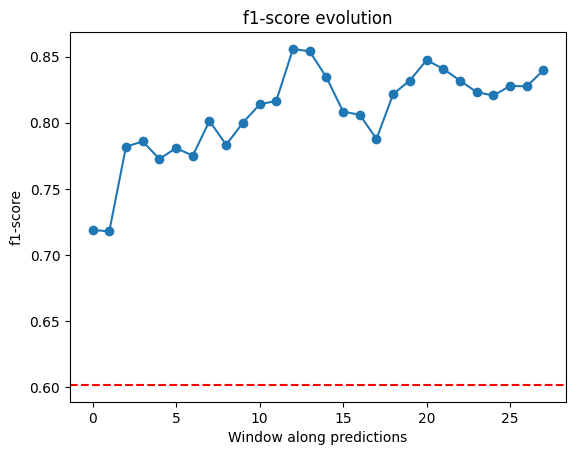

In [ ]:
# EVOLUTION OF F1-SCORE

window_size = 256
overlap = 200

step = window_size - overlap

y_win = [y_pred[i:i+window_size] for i in range(0, len(y_pred) - window_size + 1, step)]
y_win_true = [y_pred_true[i:i+window_size] for i in range(0, len(y_pred_true) - window_size + 1, step)]

assert(len(y_win) == len(y_win_true))
f1_scores = [f1_score(y_win_true[i], y_win[i], average='weighted') for i in range(len(y_win_true))]

plt.plot(range(len(f1_scores)), f1_scores, marker='o', linestyle='-')
plt.axhline(y=pre_f1_2, color='r', linestyle='--')
plt.title('f1-score evolution')
plt.xlabel('Window along predictions')
plt.ylabel('f1-score')
plt.show()

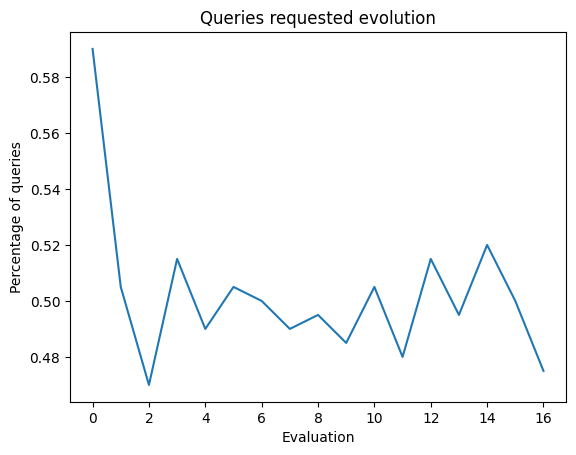

In [ ]:
# EVOLUTION OF QUERIES ASKED

plt.plot(range(len(queries_evolution_per_evaluation)), [x/200 for x in queries_evolution_per_evaluation])
plt.title('Queries requested evolution')
plt.xlabel('Evaluation')
plt.ylabel('Percentage of queries')
plt.show()

In [ ]:
print(f"Percentage of queries asked: {len(list_queries)/len(samples2_active) * 100:.2f}%")

Percentage of queries asked: 50.17%


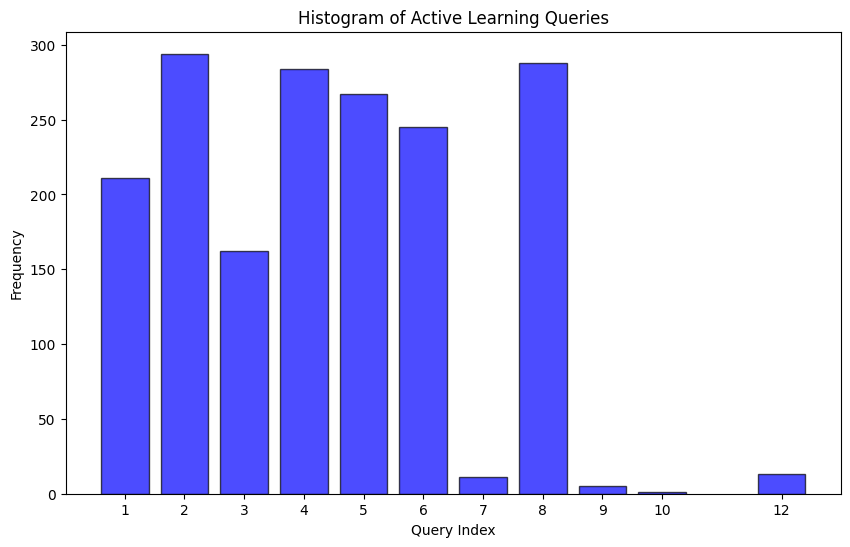

In [ ]:
# HISTOGRAM OF QUERIES ASKED PER LABEL

query_counts = Counter(list_queries)
indices = list(query_counts.keys())
frequencies = list(query_counts.values())

indices = [index + 1 for index in indices]

plt.figure(figsize=(10, 6))
plt.bar(indices, frequencies, color='blue', edgecolor='black', alpha=0.7)

plt.xlabel('Query Index')
plt.ylabel('Frequency')
plt.title('Histogram of Active Learning Queries')

plt.xticks(indices)
plt.show()


(0.0, 1.0)

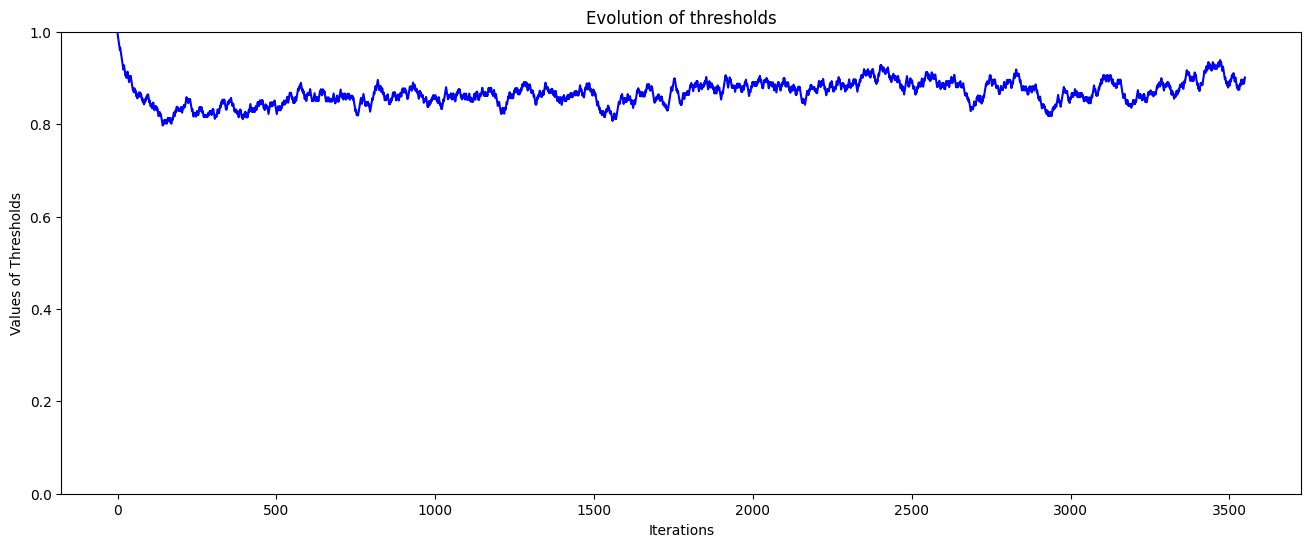

In [ ]:
# EVOLUTION OF THRESHOLD

plt.figure(figsize=(16, 6))

plt.plot(thresholds_list, color='blue')
plt.title('Evolution of thresholds')
plt.xlabel('Iterations')
plt.ylabel('Values of Thresholds')
plt.ylim([0,1])

### Results on fixed test subject

In [ ]:
print("\nPredicting...")
y_preds = model2.predict(samples2_test)

y_preds = np.argmax(y_preds, axis=1)
y_targets = np.argmax(labels_test, axis=1)

classes = list(activities_mapper.values())
print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes, labels=np.array([i for i in range(len(classes))]), digits=4, zero_division=0))


Predicting...
12/12 [==============================] - 0s 2ms/step

Classification Report:
                           precision    recall  f1-score   support

           Standing still     0.0000    0.0000    0.0000        30
     Sitting and relaxing     0.0000    0.0000    0.0000        30
               Lying down     1.0000    1.0000    1.0000        31
                  Walking     0.6383    0.9677    0.7692        31
          Climbing stairs     0.7857    0.3548    0.4889        31
      Waist bends forward     0.3000    0.7742    0.4324        31
Frontal elevation of arms     0.9375    1.0000    0.9677        30
            Knees bending     0.0000    0.0000    0.0000        34
                  Cycling     1.0000    0.9677    0.9836        31
                  Jogging     1.0000    0.2581    0.4103        31
                  Running     0.5660    1.0000    0.7229        30
                     Jump     0.9677    1.0000    0.9836        30

                 accuracy          

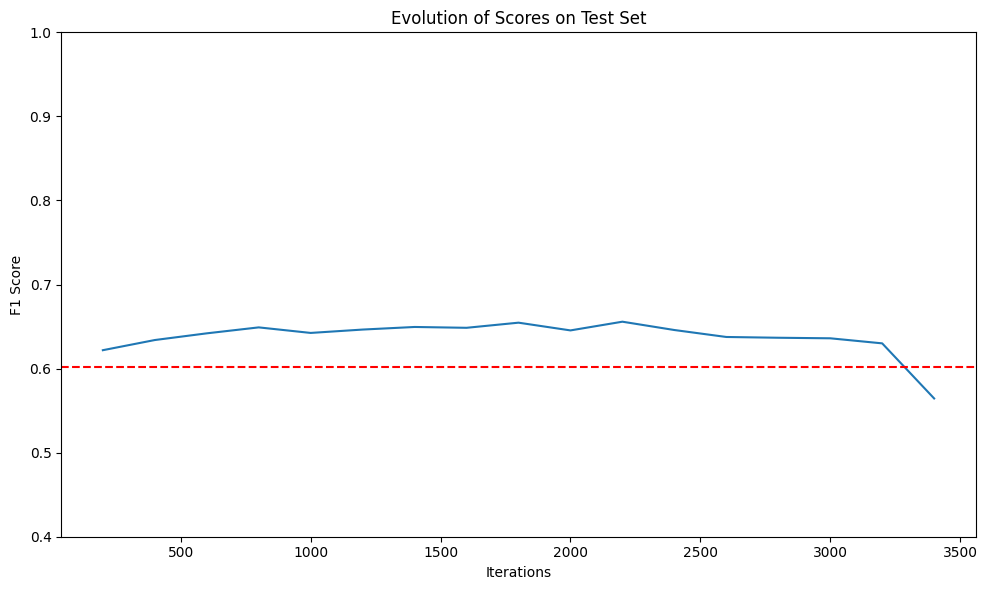

In [ ]:
# EVOLUTION OF F1-SCORE

plt.figure(figsize=(10, 6))

scores_x, scores_y = zip(*scores_evolution)
plt.plot(scores_x, scores_y)
plt.axhline(y=pre_f1_2, color='r', linestyle='--')
plt.title('Evolution of Scores on Test Set')
plt.xlabel('Iterations')
plt.ylabel('F1 Score')
plt.ylim([0.4,1])

plt.tight_layout()
plt.show()


# *CONCLUSIONS*

PREMISE: the results change significantly at each run, despite the seed fixed. The following conclusions reflect the most common results.

**RESULTS ON FINE-TUNED SUBJECT**

At first, I want to highlight that I repeated all the process of pre-train and active learning changing the subject on which we fine-tune the model, obtaining different results. Here are reported the most extreme cases:

- Sensor 1, Subject 1: strong bounce (~0.55 - ~0.85), probably due (also) to the shuffle of data

<img src="https://drive.google.com/uc?export=view&id=1mf-0vrjxl4Xs2EKc-37wOEZrZJjEutBz" width="50%">


- Sensor 1, Subject 7: very good increasing with a very low starting point, probably due to the high difference of the subject with respect to the pre-train ones.

<img src="https://drive.google.com/uc?export=view&id=1P7CPz_j4LN0Z7IoakyzjXKGpLE_SRu10" width="50%">

- Sensor 2, Subject 2: continuous up and down (~0.52 - ~0-66), probably due (also) to the shuffle of data

<img src="https://drive.google.com/uc?export=view&id=1QjUGOVhpEGDdSYI1_Sjgf3OMBhbJvGbU" width="50%">

- Sensor 2, Subject 3: very promising increasing, despite the high starting point

<img src="https://drive.google.com/uc?export=view&id=1l5eshhnbUD_ZfzNtc5I6WMQYg-qU6sAm" width="50%">


Important to specify that the performances of each subject change drastically changing the sensor considered: good/bad subject for a sensor is not consequently good/bad for the other.

In general, the f1-score has always an improvement with respect to the one reached with pre-train, as expected.

For what concerns the evolution of queries requested, there is a constant up-down in all cases, independently by subject and parameters. This is in part due to the fact that, as evident in the report of the models pre-trained, there is a very high knowledge in some activities and a very low (even null) one in others. In addition, the dynamic thresholding has to goal of adapting to the knowledge of the model, keeping always present the requests.

Another important point is the histogram of queries: it's evident that some labels are well known by the model and they are almost never asked, while others are very frequently asked. This is probably due to the fact that, from a single sensor, it is impossible to precisely understand all kinds of motion. However, also here there are some particular cases in which the activity is done by the subject in a very different way with respect to the subjects on which the model was trained. Another reason for this is that there can be difference between how much a label is correctly found and how much the model is sure on that classification: in this way, may queries can be referred to samples well classified. Due to these reasons, there can be labels with particularly frequent queries, even if their knowledge seemed to be high, and vice-versa.

Related to this, I tried to execute the same code considering both sensors' data for a single model. As expected, all labels except the first reached a f1-score greater than zero, because we're combining much more information than before. Here, during the active learning process the evolution of f1-scores is reported:

<img src="https://drive.google.com/uc?export=view&id=1aQiUg-bOdpbnQuNKOtckRXFpxWpmAJOr" width="50%">

Finally, looking at the evolution of the threshold, we can see the initial drop to reach the real necessary level and then a slow constant increase in the first part of the evolution. We can't see a big improvement because a big part of it is probably done during the time in which the threshold reaches the real level.  

**RESULTS ON FIXED TEST SUBJECT**

At first, it's clear how the fine-tune of the model on a particular subject with active learning is not a benefit for the knowledge of a general subject of the model. In fact, during all the work and trials, I have never seen a clear improvement of the accuracy of the model looking at the test subject.

However, I think in general I can be satisfied with this result, because it shows that the model does not fall in catastrophic forgetting. Instead, it keeps all the knowledge of general subjects and it also reaches very better results on a particular one.


**FINAL CONCLUSIONS**

So, what are the final conclusions of this project?

- The Active Learning made correctly its work, by fine-tuning the knowledge of the model on a single subject. However, this improvement is not visible if we try to apply the trained model on a different subject, due to their big diversity.  

- Thanks to the VAR-UNCERTAINTY strategy, the model will continue asking queries, even with very high accuracy reached. This is a positive aspect because the model will always try to improve until it reaches an accuracy of 1; but on the other side, this can be very stressful from the user point of view, because the number of queries will never decrease (in many cases, it is not even possible for the model to reach an accuracy of 1).

- Due to different positions of the sensors, the results obtained by the two models are different. In fact, considering the fine-tuned subject, we can see a f1-score during Active Learning passing from ~45% to ~65% for the right wrist sensor and from ~65% to ~85% for the left ankle sensor. Considering the performances on a new general subject that the model doesn't know, instead, the accuracy of the model stays very similar: ~62% for the right wrist sensor and ~60% for the left ankle sensor.

- Considering both sensors' signal, the model can acquire much more information and can reach final f1-scores of 0.95.